In [1]:
import tensorflow as tf
from tensorflow.keras.applications.vgg19 import VGG19
import numpy as np
import PIL.Image
import matplotlib.pyplot as plt

#### Image processing

In [2]:
# Load image and limits dimensions to 512, outputs tf tensor

def load_img(path_to_img):
    max_dim = 512
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

In [3]:
# display tf tensor as an image

def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

#### Modified VGG19 Model

In [4]:
# Creates a vgg model that returns a list of intermediate output values

def vgg_layers(layer_names):
    # paper uses avg pooling, exclude fully connected layers since no predictions
    vgg = VGG19(weights='imagenet', include_top=False, pooling = 'avg')
    vgg.trainable = False

    outputs = [vgg.get_layer(name).output for name in layer_names]

    model = tf.keras.Model([vgg.input], outputs)
    return model

#### Visualization training

In [5]:
# Image pixel values are from 0 to 1 so define a function that clips value to this range

def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [6]:
def visualization_loss(outputs,targets):
    return tf.reduce_mean((outputs-targets)**2)

In [7]:
@tf.function()
def train_step(visualization, new_model, targets, opt):
    opt = opt
    with tf.GradientTape() as tape:
        outputs = new_model(visualization)
        loss = visualization_loss(outputs,targets)

    grad = tape.gradient(loss, visualization)
    opt.apply_gradients([(grad, visualization)])
    visualization.assign(clip_0_1(visualization))
    
    return loss

In [8]:
# create randomly intialized image, which would be trained on to revisualize the designated layer
# shape matches the content_image
# return tensor Variable

def initialization(img_shape, seed = 0):
    random = tf.random.Generator.from_seed(seed) # an instance of the generator class
    random_init = random.uniform(minval=0, maxval=1, shape=img_shape) 
    tensor_to_image(random_init)
    visualization = tf.Variable(random_init)
    
    return visualization

In [9]:
# layers(list): choose which layers's output are used

def train(img_path, layers, learning_rate = 1, loss_threshold = 0.01):
    
    img = load_img(img_path)   # Load image as tensor

    new_model = vgg_layers(layers)   # new model that returns intermediate output of specified layers
    targets = new_model(tf.constant(img))   # Target output based on the original image
    
    visualization = initialization(img.shape)   #initialize tensor Variable for training

    opt = tf.optimizers.Adam(learning_rate=learning_rate, beta_1=0.99, epsilon=1e-1)
    loss = train_step(visualization, new_model, targets, opt)
    
    # train
    step = 0
    loss_list = []
    while loss > loss_threshold:
        loss = train_step(visualization, new_model, targets, opt)
        loss_list.append(loss.numpy())
        step += 1
        
        # print progress every 100 steps
        if step % 100 == 0:
            print(f'{step}: {loss.numpy()}')
            
    return visualization, loss_list, step

#### Implementation 3

In [10]:
layers3 = ['block5_conv3']
visualization3, loss_list3, step3 = train('cat.jpg', layers3, learning_rate = 1, loss_threshold = 0.04)

2022-01-25 19:05:03.907344: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-25 19:05:05.429982: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


100: 0.19284920394420624
200: 0.17433032393455505
300: 0.1596495807170868
400: 0.14909400045871735
500: 0.14125224947929382
600: 0.13493545353412628
700: 0.12946347892284393
800: 0.12448686361312866
900: 0.11972538381814957
1000: 0.11511407792568207
1100: 0.1103595718741417
1200: 0.1055522933602333
1300: 0.10045565664768219
1400: 0.0946442186832428
1500: 0.0882018581032753
1600: 0.08208365738391876
1700: 0.0772114098072052
1800: 0.0732414647936821
1900: 0.06981171667575836
2000: 0.06663016974925995
2100: 0.06345131248235703
2200: 0.060379575937986374
2300: 0.057425178587436676
2400: 0.0546136200428009
2500: 0.05194082856178284
2600: 0.049362387508153915
2700: 0.04696512594819069
2800: 0.044752586632966995
2900: 0.042743247002363205
3000: 0.040887560695409775


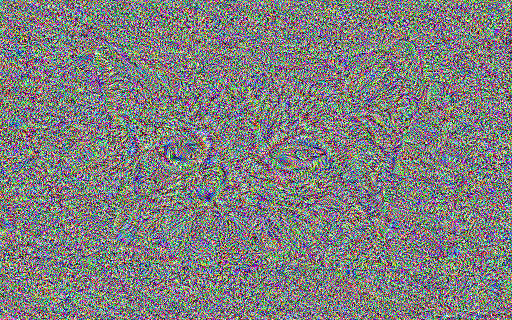

In [11]:
tensor_to_image(visualization3)

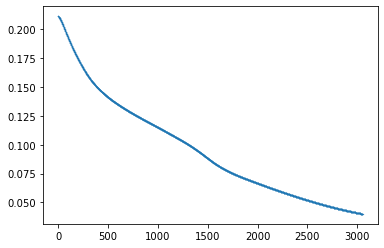

In [14]:
# Visualize loss
plt.scatter(np.arange(step3)+1, loss_list3, s=0.1)
plt.show()

In [10]:
layers3 = ['block5_conv3']
visualization3, loss_list3, step3 = train('cat.jpg', layers3, learning_rate = 1, loss_threshold = 0.01)

2022-01-26 00:10:54.113602: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-26 00:10:55.542527: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


100: 0.19284920394420624
200: 0.17433032393455505
300: 0.1596495807170868
400: 0.14909400045871735
500: 0.14125224947929382
600: 0.13493545353412628
700: 0.12946347892284393
800: 0.12448686361312866
900: 0.11972538381814957
1000: 0.11511407792568207
1100: 0.1103595718741417
1200: 0.1055522933602333
1300: 0.10045565664768219
1400: 0.0946442186832428
1500: 0.0882018581032753
1600: 0.08208365738391876
1700: 0.0772114098072052
1800: 0.0732414647936821
1900: 0.06981171667575836
2000: 0.06663016974925995
2100: 0.06345131248235703
2200: 0.060379575937986374
2300: 0.057425178587436676
2400: 0.0546136200428009
2500: 0.05194082856178284
2600: 0.049362387508153915
2700: 0.04696512594819069
2800: 0.044752586632966995
2900: 0.042743247002363205
3000: 0.040887560695409775
3100: 0.039235420525074005
3200: 0.03779018670320511
3300: 0.03654410317540169
3400: 0.03543296083807945
3500: 0.03441386669874191
3600: 0.03347513824701309
3700: 0.032597944140434265
3800: 0.03176622837781906
3900: 0.0309858955442

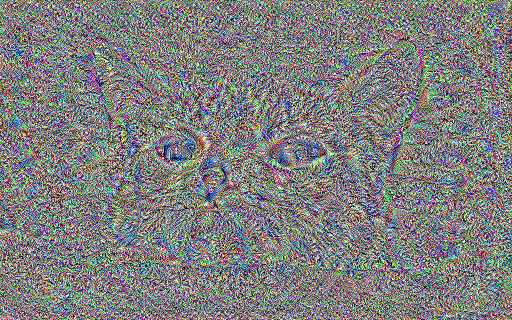

In [11]:
tensor_to_image(visualization3)

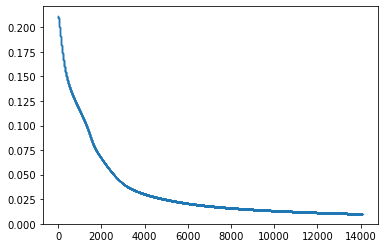

In [12]:
# Visualize loss
plt.scatter(np.arange(step3)+1, loss_list3, s=0.1)
plt.show()

In [ ]:
layers4 = ['block4_conv3']
visualization4, loss_list4, step4 = train('cat.jpg', layers4)

#### Implementation 2

In [10]:
layers = ['block3_conv3']
visualization, loss_list, step = train('cat.jpg', layers)

2022-01-25 15:16:57.670914: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-25 15:16:59.005063: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


100: 15.736150741577148
200: 8.51949691772461
300: 4.568935394287109
400: 2.4119720458984375
500: 1.1291736364364624
600: 0.5890876054763794
700: 0.37002256512641907
800: 0.26549050211906433
900: 0.20782127976417542
1000: 0.173105388879776
1100: 0.15007732808589935
1200: 0.1336422711610794
1300: 0.12132833153009415
1400: 0.1118619441986084
1500: 0.104214608669281
1600: 0.0977156013250351
1700: 0.09208550304174423
1800: 0.08714155107736588
1900: 0.08276968449354172
2000: 0.07882905006408691
2100: 0.07522813975811005
2200: 0.07195884734392166
2300: 0.06900971382856369
2400: 0.06634772568941116
2500: 0.06393472850322723
2600: 0.06173758953809738
2700: 0.05970942974090576
2800: 0.057818662375211716
2900: 0.05605664104223251
3000: 0.054413191974163055
3100: 0.05287199094891548
3200: 0.051397521048784256
3300: 0.049974821507930756
3400: 0.04863316938281059
3500: 0.04736161231994629
3600: 0.046161308884620667
3700: 0.04497472941875458
3800: 0.04376668110489845
3900: 0.042522601783275604
4000:

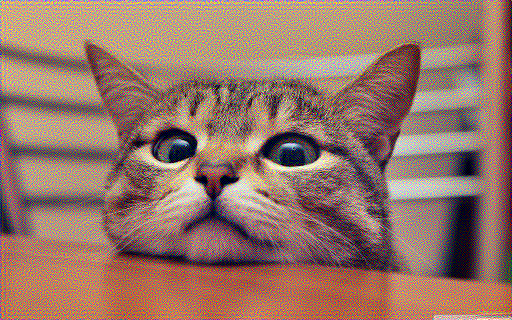

In [11]:
# Display the reconstruction
tensor_to_image(visualization)

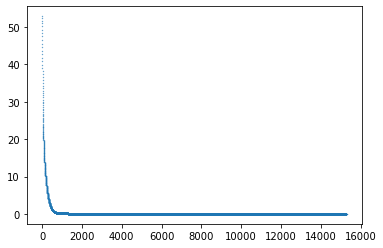

In [12]:
# Visualize loss
plt.scatter(np.arange(step)+1, loss_list, s=0.1)
plt.show()

#### Implementation 1

In [25]:
layers = ['block1_conv1']
visualization, loss_list, step = train('cat.jpg', layers)

2022-01-24 22:03:25.269879: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


100: 0.11474701017141342
200: 0.11411670595407486
300: 0.11332418024539948
400: 0.11241360753774643
500: 0.1114121675491333
600: 0.1103389710187912
700: 0.10920844972133636
800: 0.10803201049566269
900: 0.1068190336227417
1000: 0.10557718575000763
1100: 0.10431282222270966
1200: 0.1030314713716507
1300: 0.10173793882131577
1400: 0.10043623298406601
1500: 0.09912987053394318
1600: 0.09782178699970245
1700: 0.09651456773281097
1800: 0.09521065652370453
1900: 0.09391177445650101
2000: 0.09261979907751083
2100: 0.09133618324995041
2200: 0.09006229788064957
2300: 0.08879923820495605
2400: 0.0875481367111206
2500: 0.08630969375371933
2600: 0.08508466184139252
2700: 0.08387374877929688
2800: 0.08267764747142792
2900: 0.08149666339159012
3000: 0.08033111691474915
3100: 0.07918146252632141
3200: 0.07804803550243378
3300: 0.07693096995353699
3400: 0.07583042979240417
3500: 0.07474640756845474
3600: 0.07367902994155884
3700: 0.072628453373909
3800: 0.0715947225689888
3900: 0.07057783752679825
400

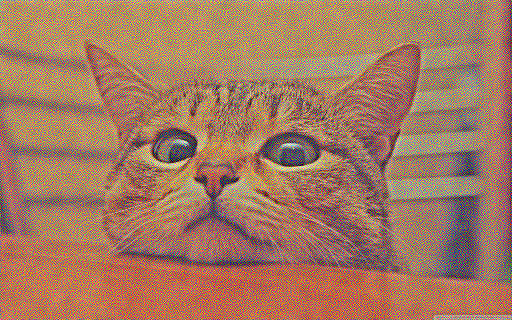

In [26]:
# Display the reconstruction
tensor_to_image(visualization)

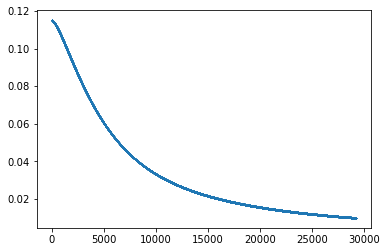

In [32]:
# Visualize loss
plt.scatter(np.arange(step)+1, loss_list, s=0.1)
plt.show()

#### Implementation 0: without the train function.

In [34]:
@tf.function()
def train_step0(visualization):
    with tf.GradientTape() as tape:
        outputs = new_model(visualization)
        loss = visualization_loss(outputs,targets)

    grad = tape.gradient(loss, visualization)
    opt.apply_gradients([(grad, visualization)])
    visualization.assign(clip_0_1(visualization))
    
    return loss

In [49]:
# Load image
img_path = 'content_beach.jpeg'
img = load_img(img_path)
img.shape

TensorShape([1, 368, 511, 3])

In [36]:
# training targets: output of model in response to the original image
layers = ['block1_conv1']
new_model = vgg_layers(layers)
targets = new_model(tf.constant(img))

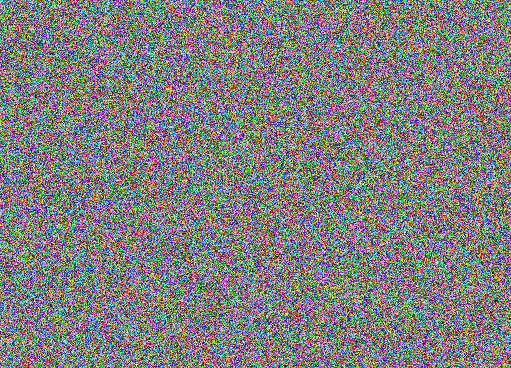

In [37]:
# create randomly intialized image, which would be trained on to revisualize the designated layer
random = tf.random.Generator.from_seed(0) # an instance of the generator class
random_init = random.uniform(minval=0, maxval=1, shape=(1,368, 511, 3)) # shape matches the content_image
visualization = tf.Variable(random_init)

tensor_to_image(random_init)

In [101]:
opt = tf.optimizers.Adam(learning_rate=1, beta_1=0.99, epsilon=1e-1)

In [110]:
# train
step = 0
loss = train_step0(visualization)
while loss > 0.01:
    loss = train_step0(visualization)
    step += 1
    if step % 100 == 0:
        print(f'{step}: {loss.numpy()}')
    
    
"""
train_steps = int(1e5)
for step in range(train_steps):
    loss = train_step(visualization)  
"""

100: 0.09863023459911346
200: 0.09728085994720459
300: 0.0959400162100792
400: 0.09460940212011337
500: 0.09329045563936234
600: 0.09198449552059174
700: 0.09069254994392395
800: 0.08941546082496643
900: 0.08815410733222961
1000: 0.08690899610519409
1100: 0.0856807604432106
1200: 0.08446994423866272
1300: 0.08327668905258179
1400: 0.0821012556552887
1500: 0.08094395697116852
1600: 0.07980495691299438
1700: 0.07868438214063644
1800: 0.07758230715990067
1900: 0.07649877667427063
2000: 0.07543377578258514
2100: 0.0743873119354248
2200: 0.07335929572582245
2300: 0.07234960049390793
2400: 0.0713581070303917
2500: 0.07038477808237076
2600: 0.06942939013242722
2700: 0.06849189102649689
2800: 0.06757202744483948
2900: 0.0666695237159729
3000: 0.06578421592712402
3100: 0.06491585820913315
3200: 0.06406424939632416
3300: 0.06322918832302094
3400: 0.062410417944192886
3500: 0.061607617884874344
3600: 0.06082060560584068
3700: 0.06004912033677101
3800: 0.05929284170269966
3900: 0.05855152010917663

KeyboardInterrupt: 

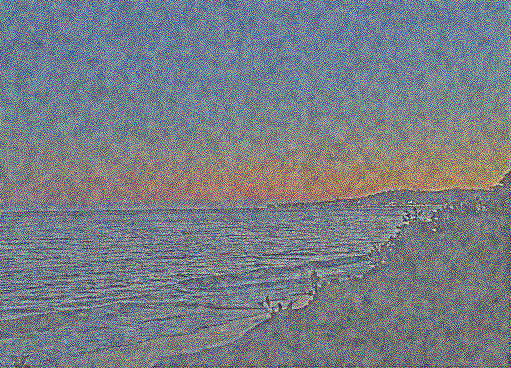

In [111]:
tensor_to_image(visualization)

#### Under construction: training code that continues on

In [41]:
def cont_train(img_path, layers, learning_rate, loss_threshold, last_visualization = False, last_step = 0, last_loss_list = []):
    
    img = load_img(img_path)  
    new_model = vgg_layers(layers)
    targets = new_model(tf.constant(img))
    
    if last_visualization == False:
        visualization = initialization(img.shape)
    else:
        visualization = last_visualization
    
    opt = tf.optimizers.Adam(learning_rate=learning_rate, beta_1=0.99, epsilon=1e-1)
    loss = train_step(visualization)
    
    step = last_step
    loss_array = last_loss_list
    
    while loss > loss_threshold:
        loss = train_step(visualization)
        loss_list.append(loss.numpy())
        step += 1
        
        # print progress every 100 steps
        if step % 100 == 0:
            print(f'{step}: {loss.numpy()}')
    
    return visualization, loss_list, step